In [1]:
# use detectron env
import torch
import matplotlib.pyplot as plt
import os
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
import numpy as np
import pickle
import shapely
import pandas as pd

### Detect windows, doors and other facade elements and compute WWR (Window-to-Wall Ratio)
Pre-trained detectron net is used to detect facade elements. With help of outside surface in image, the percentage of windows, doors etc. from the total outside area is calculated

In [3]:
# important paths
data_dir = "./../../data"
image_dir = data_dir + "/images"
models_dir = data_dir + "/models"
dataframes_dir = data_dir + "/dataframes"

In [4]:
#parameters for Detectron net
MetadataCatalog.get("test_set").set(thing_classes=['fenster', 'haustuer', 'gaube', 'shop', 'dachfenster'])

#load detectron model
new_cfg = get_cfg()
if not torch.cuda.is_available():
    print('not using gpu acceleration')
    new_cfg.MODEL.DEVICE = 'cpu'
new_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
new_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

new_cfg.MODEL.WEIGHTS = models_dir + "/train_mixed_b-400_LR0018_BS1024_MAXITER6339.pth"
new_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85  # set a custom testing threshold
predictor = DefaultPredictor(new_cfg)
#window_class = 0
#gauben_class = 2
#dachfenster_class = 4

not using gpu acceleration


/home/isabell/anaconda3/envs/det_aruscha/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


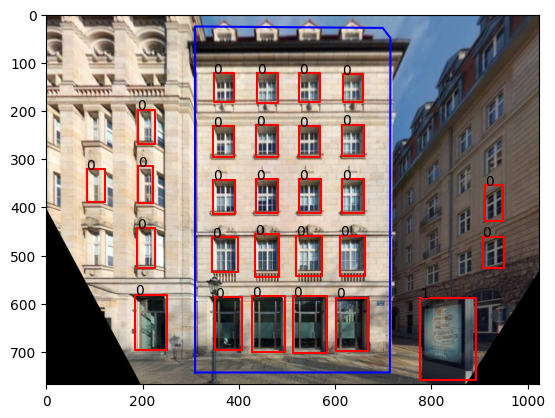

In [7]:
# for example image, read image and the outside surfaces in the image 
id_img = "combined_353"
imgfilepath = image_dir + "/rectified_images_house/" + id_img + ".jpg"
outside_surface = image_dir + "/rectified_walls_outside_surfaces/" + id_img + ".pkl"
im = plt.imread(imgfilepath)

# use detection model and extract boxes and the according classes (0 is window, 1 is door)
outputs = predictor(im)
boxes = outputs["instances"].pred_boxes
classes = outputs["instances"].pred_classes

# show image and also plot outside surface in blue, detected elements in red
plt.imshow(im)
for box, label in zip(np.array(boxes), np.array(classes)):
    surface = np.array([[box[0],box[1]], [box[0], box[3]], [box[2],box[3]], [box[2],box[1]], [box[0],box[1]]])
    plt.plot(surface[:,0], surface[:,1], color = "red")
    plt.text(x = box[0], y = box[1], s = label)
with open(outside_surface, 'rb') as f:
    surface_coords_in_img = pickle.load(f)  
surface_coords_in_img = np.array(surface_coords_in_img)
plt.plot(surface_coords_in_img[:,0], surface_coords_in_img[:,1], color = "blue")

plt.show()

total area in pixels²: 290765.5
wwr: 0.2819 -> 28.19%


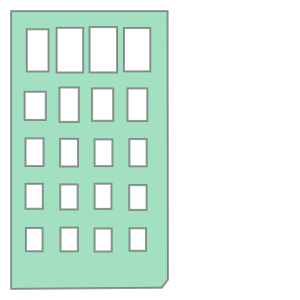

In [ ]:
# calculate window-to-wall ratio

# make outside surface to polygon
total_area_polygon = shapely.geometry.Polygon(surface_coords_in_img)

# make all detected boxes (windows or else) to multipolygon
windows_multi_polygon = []
for box in np.array(boxes):
    surface = np.array([[box[0],box[1]], [box[0], box[3]], [box[2],box[3]], [box[2],box[1]], [box[0],box[1]]])
    windows_multi_polygon.append(shapely.geometry.Polygon(surface))

windows_multi_polygon = shapely.geometry.MultiPolygon(windows_multi_polygon)

# take difference of outside surface with window polygon
solid_wall_polygon = total_area_polygon.difference(windows_multi_polygon) # upside down, but does not matter for area calculation

print("total area in pixel:", total_area_polygon.area)
print("wwr:", round(1 - (solid_wall_polygon.area / total_area_polygon.area), 4), "->", str(round((1 - (solid_wall_polygon.area / total_area_polygon.area))*100, 2)) + "%")

solid_wall_polygon

### Do this for all images

In [9]:
def calculate_wwr(id_img, image_dir, show = False):
    ''' 
    Calculates the Window-to-Wall Ratio (WWR) for a given image of a building facade.

    This function reads a rectified image and its corresponding outside surface coordinates, 
    predicts facade elements (such as windows) using a pre-trained model, and computes the 
    WWR by comparing the area of the detected windows to the total area of the wall surface.

    PARAMS:
    * id_img: A string representing the identifier for the image (used to construct file paths).
    * image_dir: A string representing the directory where the images and surface data are stored.
    * show: (Optional) A boolean indicating whether to display the image with detected windows and surfaces.

    RESULTS:
    * Window-to-Wall Ratio (WWR) as a float, rounded to four decimal places.

    The function also saves the area of the solid wall (excluding windows) in Well-Known Text (WKT) format 
    to a specified directory.
    '''
    # get paths to image and the outside surfaces in the image; read image in
    imgfilepath = image_dir + "/rectified_images_house/" + id_img + ".jpg"
    outside_surface = image_dir + "/rectified_walls_outside_surfaces/" + id_img + ".pkl" 

    im = plt.imread(imgfilepath)

    # predict facade elements and extract boxes from result
    outputs = predictor(im)
    boxes = outputs["instances"].pred_boxes
    
    # show image with predicted windows and co if wanted
    if show:
        classes = outputs["instances"].pred_classes
        plt.imshow(im)
        for box, label in zip(np.array(boxes), np.array(classes)):
            surface = np.array([[box[0],box[1]], [box[0], box[3]], [box[2],box[3]], [box[2],box[1]], [box[0],box[1]]])
            plt.plot(surface[:,0], surface[:,1], color = "red")
            plt.text(x = box[0], y = box[1], s = label)
        with open(outside_surface, 'rb') as f:
            surface_coords_in_img = pickle.load(f)  
        surface_coords_in_img = np.array(surface_coords_in_img)
        plt.plot(surface_coords_in_img[:,0], surface_coords_in_img[:,1], color = "blue")

        plt.show()

    # read outside surface coords of wall in image
    with open(outside_surface, 'rb') as f:
        surface_coords_in_img = pickle.load(f)  

    # make outside surface to polygon
    total_area_polygon = shapely.geometry.Polygon(surface_coords_in_img).buffer(0)
    
    # make all detected boxes (windows or else) to multipolygon
    windows_multi_polygon = []
    for box in np.array(boxes):
        surface = np.array([[box[0],box[1]], [box[0], box[3]], [box[2],box[3]], [box[2],box[1]], [box[0],box[1]]])
        windows_multi_polygon.append(shapely.geometry.Polygon(surface).buffer(0))

    windows_multi_polygon = shapely.geometry.MultiPolygon(windows_multi_polygon).buffer(0)

    # take difference of outside surface with window polygon
    solid_wall_polygon = total_area_polygon.difference(windows_multi_polygon) 

    # transform to well known text in order to save it
    wkt_poly = solid_wall_polygon.wkt

    # Save solid_wall_area
    with open(image_dir + "/solid_wall_areas/" + id_img + '.pkl', 'wb') as f:
        pickle.dump(wkt_poly, f) 
    
    # return Window-to-wall ratio
    return round(1 - (solid_wall_polygon.area / total_area_polygon.area), 4)

In [10]:
df2_walls = pd.read_csv(dataframes_dir + "/df2_walls_03_with_camera_id.csv")

df2_walls

,part_id,wall_id,surface_coordinates,area,normal_vec,wall_height,angle_to_north,cardinal_direction,outside_surface_coordinates,outside_area,outside_subtracted_walls,outside,outside_groundbound,outside_bounding_box,interesting_for_image,camera_id_for_image
0,DESN_000WFP8_main,UUID_0bbcf935-b8f5-49d6-8931-af23caaa2903,"[(311035.68, 5688001.348, 123.998), (311030.45...",23.453131,"[0.21849090832257181, -0.9758389841466559, 0.0]",4.376,167.379588,south,"[[(311035.68, 5688001.348, 119.622), (311030.4...",0.021438,['UUID_3d057299-6871-46e5-9ce5-a6f5673412ef'],False,True,"[(311035.68, 5688001.348, 119.626), (311030.45...",False,not_searched_for
1,DESN_000WFP8_main,UUID_d94fd64c-53e3-4563-9fe1-3a9b840fb214,"[(311030.45, 5688000.177, 123.998), (311028.45...",30.821034,"[-0.9743074935930067, -0.22522190818948584, 0.0]",4.376,256.984072,east,"[[(311030.45, 5688000.177, 123.998), (311028.4...",30.821034,[],True,True,"[(311030.45, 5688000.177, 123.998), (311028.45...",True,none_found
2,DESN_000WFP8_main,UUID_78e9d3b0-4fdd-4fe2-94fe-06ce701ffa86,"[(311028.453, 5688008.816, 122.198), (311033.6...",13.683157,"[-0.20407453903918482, 0.9789553526672932, 0.0]",2.576,348.224671,north,"[[(311028.453, 5688008.816, 122.198), (311033....",13.683157,[],True,True,"[(311028.453, 5688008.816, 122.198), (311033.6...",True,none_found
3,DESN_000WFP8_main,UUID_41f1c6a6-8857-4ce3-b0f5-3eb1aaa5bc54,"[(311033.653, 5688009.9, 122.198), (311035.68,...",30.550349,"[0.973041327471674, 0.2306308197794957, 0.0]",4.376,76.665786,west,"[[(311033.653, 5688009.9, 122.198), (311035.68...",30.550349,[],True,True,"[(311033.653, 5688009.9, 123.998), (311035.68,...",True,none_found
4,DESN_1389772836945_13701754,UUID_465e5cc3-707b-48e4-a7ee-81a03a9e2ee6,"[(311036.776, 5687996.602, 124.441), (311031.5...",25.802259,"[0.2170292510132926, -0.9761651008946228, 0.0]",4.815,167.465394,south,"[[(311036.776, 5687996.602, 124.441), (311031....",25.802259,[],True,True,"[(311036.776, 5687996.602, 124.441), (311031.5...",True,WE974KPT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921477,DESN_{FFEE841E-E7EB-40A8-B30D-A6D687B1F3E1}_main,combined_148030,"[(313850.567, 5696064.5, 134.154), (313850.567...",21.854214,"[-0.3771581149334625, -0.9261488845427809, 0.0]",2.274,202.157760,south,"[[(313850.567, 5696064.5, 136.428), (313851.83...",3.495069,['fme-gen-96bcba7e-1644-4f94-83c4-78c9255c4fd7'],False,True,"[(313859.468, 5696060.875, 136.428), (313850.5...",False,not_searched_for
921478,DESN_{FFF09CB1-4832-4013-BCA0-B171BB394B1D}_main,combined_148031,"[(311382.012, 5696641.969, 125.313), (311383.2...",9.705224,"[-0.9554153043036776, 0.2952652981681242, 0.0]",2.747,287.173446,east,"[[(311382.012, 5696641.969, 125.313), (311383....",9.705224,[],True,True,"[(311382.012, 5696641.969, 128.06), (311383.20...",False,not_searched_for
921479,DESN_{FFF09CB1-4832-4013-BCA0-B171BB394B1D}_main,combined_148032,"[(311388.235, 5696644.284, 125.313), (311387.0...",9.705224,"[0.9554153043036776, -0.2952652981681242, 0.0]",2.747,107.173446,west,"[[(311388.235, 5696644.284, 125.313), (311387....",9.705224,[],True,True,"[(311388.235, 5696644.284, 128.06), (311387.03...",False,not_searched_for
921480,DESN_{FFF313F9-F3A1-4760-8F91-9C9A4B7F261B}_main,combined_148033,"[(310549.938, 5691404.49, 114.324), (310549.93...",28.322057,"[-0.9848609099134684, 0.17334643960697627, 0.0]",2.746,279.982445,east,"[[(310549.938, 5691404.49, 114.324), (310549.9...",28.322057,[],True,True,"[(310548.15, 5691394.332, 117.07), (310549.938...",True,none_found


In [ ]:
# runs about 3500 mins -> 60h
# take all rectified images that were extracted (about 106.000)
available_img_names = os.listdir(image_dir + "/rectified_images_house")

# for each available image, calculate wwr and save in df
df2_walls["wwr"] = -1.0
for count, img_name in enumerate(available_img_names):

    if count % 5000 == 0:
        print(count, "/", len(available_img_names))
        # save intermediate state
        df2_walls.to_csv(dataframes_dir + "/df2_walls_with_wwr_intermediate.csv", index = False)

    try:
        img_id = img_name.split(".jpg")[0]
        wwr = calculate_wwr(img_id, image_dir, show = False)
        df2_walls.loc[df2_walls["wall_id"] == img_id, "wwr"] = wwr
    except Exception as e:
        print("for id", img_id, "an error occured:", e)


0 / 106235
5000 / 106235
10000 / 106235
15000 / 106235
20000 / 106235
25000 / 106235
30000 / 106235
35000 / 106235
40000 / 106235
45000 / 106235
50000 / 106235
55000 / 106235
60000 / 106235
65000 / 106235
70000 / 106235
75000 / 106235
80000 / 106235
85000 / 106235
90000 / 106235
95000 / 106235
100000 / 106235
105000 / 106235


In [33]:
# convert -1 to nan and save final table with all wwrs
df2_walls["wwr"] = df2_walls["wwr"].replace(-1, np.nan)
print("WWR was extracted for", len(df2_walls[~df2_walls["wwr"].isna()]), "walls")
df2_walls.to_csv(dataframes_dir + "/df2_walls_04_with_wwr.csv", index = False)

WWR was extracted for 106235 walls


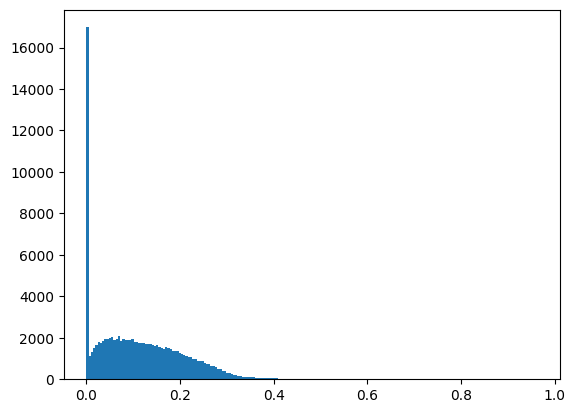

In [35]:
plt.hist(df2_walls[~df2_walls["wwr"].isna()]["wwr"], bins = 200)
plt.show()

In [ ]:
# show some results
counter = 0
for wall_id in df2_walls[~df2_walls["wwr"].isna()]["wall_id"]:
    imgfilepath = image_dir + "/rectified_images_house/" + wall_id + ".jpg"
    #outside_surface = image_dir + "/rectified_walls_outside_surfaces/" + wall_id + ".pkl" 
    solid_wall_area = image_dir + "/solid_wall_areas/" + wall_id + ".pkl"

    im = plt.imread(imgfilepath)
    plt.imshow(im)
    #with open(outside_surface, 'rb') as f:
    #    surface_coords_in_img = pickle.load(f) 
    with open(solid_wall_area, 'rb') as f:
        swa_in_image = pickle.load(f)  
    surface_coords_in_img = np.array(surface_coords_in_img)

    exterior = np.array(shapely.from_wkt(swa_in_image).exterior.coords)
    plt.plot(exterior[:,0], exterior[:,1], color = "blue")

    for interior in shapely.from_wkt(swa_in_image).interiors:
        interior_coords = np.array(interior.coords)
        plt.plot(interior_coords[:,0], interior_coords[:,1], color = "red")

    plt.show()

    if counter > 10: 
        break
    counter += 1

# not executed and shown due to license reasons